
===  DEEP Q-LEARNING (DQN) ===
Episodio 0: Recompensa = 18.0, Epsilon = 1.000, Media = 18.0
Episodio 30: Recompensa = 255.0, Epsilon = 0.010, Media = 73.4
Episodio 60: Recompensa = 217.0, Epsilon = 0.010, Media = 300.8
Episodio 90: Recompensa = 500.0, Epsilon = 0.010, Media = 401.8
Episodio 120: Recompensa = 500.0, Epsilon = 0.010, Media = 393.5
Episodio 150: Recompensa = 171.0, Epsilon = 0.010, Media = 259.7
Episodio 180: Recompensa = 324.0, Epsilon = 0.010, Media = 157.0
Episodio 210: Recompensa = 9.0, Epsilon = 0.010, Media = 242.1
Episodio 240: Recompensa = 10.0, Epsilon = 0.010, Media = 9.6
Episodio 270: Recompensa = 10.0, Epsilon = 0.010, Media = 23.0


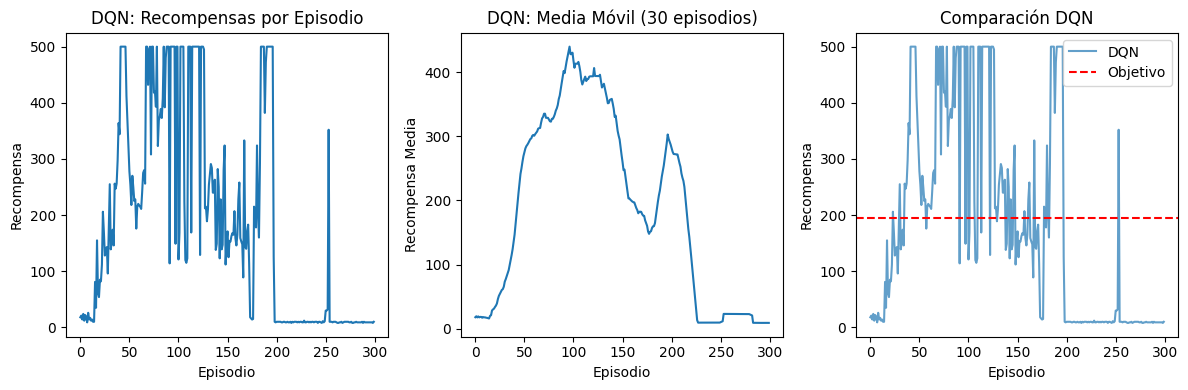

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
# =============================================================================
# DEEP Q-LEARNING (DQN) - COMBINA Q-LEARNING CON REDES NEURONALES
# =============================================================================

import torch
import torch.nn as nn
print("\n===  DEEP Q-LEARNING (DQN) ===")

class RedDQN(nn.Module):
    def __init__(self, dim_entrada, dim_salida):
        super().__init__()
        self.capa1 = nn.Linear(dim_entrada, 128)
        self.capa2 = nn.Linear(128, 128)
        self.capa3 = nn.Linear(128, dim_salida)
    
    def forward(self, x):
        x = torch.relu(self.capa1(x))
        x = torch.relu(self.capa2(x))
        return self.capa3(x)  # Q-values para cada acción

class AgenteDQN:
    def __init__(self, dim_entrada, dim_salida, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995):
        self.dim_entrada = dim_entrada
        self.dim_salida = dim_salida
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        
        # DOS REDES: Q-network (actual) y Target-network (estable)
        self.q_network = RedDQN(dim_entrada, dim_salida)
        self.target_network = RedDQN(dim_entrada, dim_salida)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experiencia replay - memoria de transiciones
        self.memoria = []
        self.tamano_lote = 32
        self.contador_actualizacion = 0
        
        # Inicializar target network igual a Q-network
        self.actualizar_target_network()
    
    def actualizar_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def guardar_experiencia(self, estado, accion, recompensa, siguiente_estado, terminado):
        self.memoria.append((estado, accion, recompensa, siguiente_estado, terminado))
        # Mantener solo últimas 10000 experiencias
        if len(self.memoria) > 10000:
            self.memoria.pop(0)
    
    def elegir_accion(self, estado):
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.dim_salida)  # Exploración
        else:
            with torch.no_grad():
                estado_tensor = torch.FloatTensor(estado)
                q_values = self.q_network(estado_tensor)
                return torch.argmax(q_values).item()  # Explotación
    
    def entrenar(self):
        if len(self.memoria) < self.tamano_lote:
            return
        
        # Samplear lote aleatorio de memoria
        lote = np.random.choice(len(self.memoria), self.tamano_lote, replace=False)
        estados, acciones, recompensas, siguientes_estados, terminados = zip(*[self.memoria[i] for i in lote])
        
        # Convertir a tensores
        estados = torch.FloatTensor(estados)
        acciones = torch.LongTensor(acciones)
        recompensas = torch.FloatTensor(recompensas)
        siguientes_estados = torch.FloatTensor(siguientes_estados)
        terminados = torch.BoolTensor(terminados)
        
        # Q-values actuales
        q_actual = self.q_network(estados).gather(1, acciones.unsqueeze(1))
        
        # Q-values objetivo
        with torch.no_grad():
            max_q_siguiente = self.target_network(siguientes_estados).max(1)[0]
            objetivo = recompensas + self.gamma * max_q_siguiente * ~terminados
        
        # Pérdida MSE entre Q actual y Q objetivo
        perdida = nn.MSELoss()(q_actual.squeeze(), objetivo)
        
        # Backpropagation
        self.optimizer.zero_grad()
        perdida.backward()
        self.optimizer.step()
        
        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Actualizar target network periódicamente
        self.contador_actualizacion += 1
        if self.contador_actualizacion % 10 == 0:
            self.actualizar_target_network()

def entrenar_dqn():
    env = gym.make('CartPole-v1')
    
    agente = AgenteDQN(
        dim_entrada=4,
        dim_salida=2,
        lr=0.001,
        gamma=0.99,
        epsilon=1.0,        # 100% exploración inicial
        epsilon_decay=0.995 # Decaimiento lento
    )
    
    recompensas_totales = []
    
    for episodio in range(300):
        estado, _ = env.reset()
        recompensa_episodio = 0
        terminado = False
        truncado = False
        
        while not (terminado or truncado):
            accion = agente.elegir_accion(estado)
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            
            # Guardar experiencia
            agente.guardar_experiencia(estado, accion, recompensa, siguiente_estado, terminado)
            
            # Entrenar con experience replay
            agente.entrenar()
            
            estado = siguiente_estado
            recompensa_episodio += recompensa
        
        recompensas_totales.append(recompensa_episodio)
        
        if episodio % 30 == 0:
            media_actual = np.mean(recompensas_totales[-30:]) if len(recompensas_totales) >= 30 else np.mean(recompensas_totales)
            print(f"Episodio {episodio}: Recompensa = {recompensa_episodio}, Epsilon = {agente.epsilon:.3f}, Media = {media_actual:.1f}")
    
    env.close()
    
    # Gráficos comparativos
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(recompensas_totales)
    plt.title('DQN: Recompensas por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    
    plt.subplot(1, 3, 2)
    media_movil = [np.mean(recompensas_totales[max(0,i-29):i+1]) for i in range(len(recompensas_totales))]
    plt.plot(media_movil)
    plt.title('DQN: Media Móvil (30 episodios)')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Media')
    
    plt.subplot(1, 3, 3)
    # Comparar métodos (simulados)
    episodios = range(len(recompensas_totales))
    plt.plot(episodios, recompensas_totales, alpha=0.7, label='DQN')
    plt.axhline(y=195, color='red', linestyle='--', label='Objetivo')
    plt.title('Comparación DQN')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return agente

# Ejecutar DQN
agente_dqn = entrenar_dqn()


🎮 MUNDO 10x10 - DEEP Q-LEARNING (DQN)

🔴 FASE 1: AGENTE ALEATORIO (NO ENTRENADO)

📹 Grabando Episodio 1 - Agente Aleatorio
  ⏰ Episodio 1: Se agotaron los pasos

📹 Grabando Episodio 2 - Agente Aleatorio
  ⏰ Episodio 2: Se agotaron los pasos

🔄 ENTRENANDO DQN (800 episodios)...
Episodio 0: Recompensa = -11.55, ε = 0.963, Media = -11.55
Episodio 100: Recompensa = 68.80, ε = 0.010, Media = 42.00
Episodio 200: Recompensa = 68.80, ε = 0.010, Media = 67.46
Episodio 300: Recompensa = 62.60, ε = 0.010, Media = 67.21
Episodio 400: Recompensa = 68.80, ε = 0.010, Media = 67.65
Episodio 500: Recompensa = 68.80, ε = 0.010, Media = 67.90
Episodio 600: Recompensa = 68.60, ε = 0.010, Media = 67.68
Episodio 700: Recompensa = 67.60, ε = 0.010, Media = 67.41

🟢 FASE 3: AGENTE DQN ENTRENADO

📹 Grabando Episodio 1 - DQN
  ⏰ Episodio 1: Se agotaron los pasos

📹 Grabando Episodio 2 - DQN
  ⏰ Episodio 2: Se agotaron los pasos

🎬 CREANDO GIFS ANIMADOS...
  ✅ GIF creado: estados_dqn/aleatorio_episodio_000.gif
 

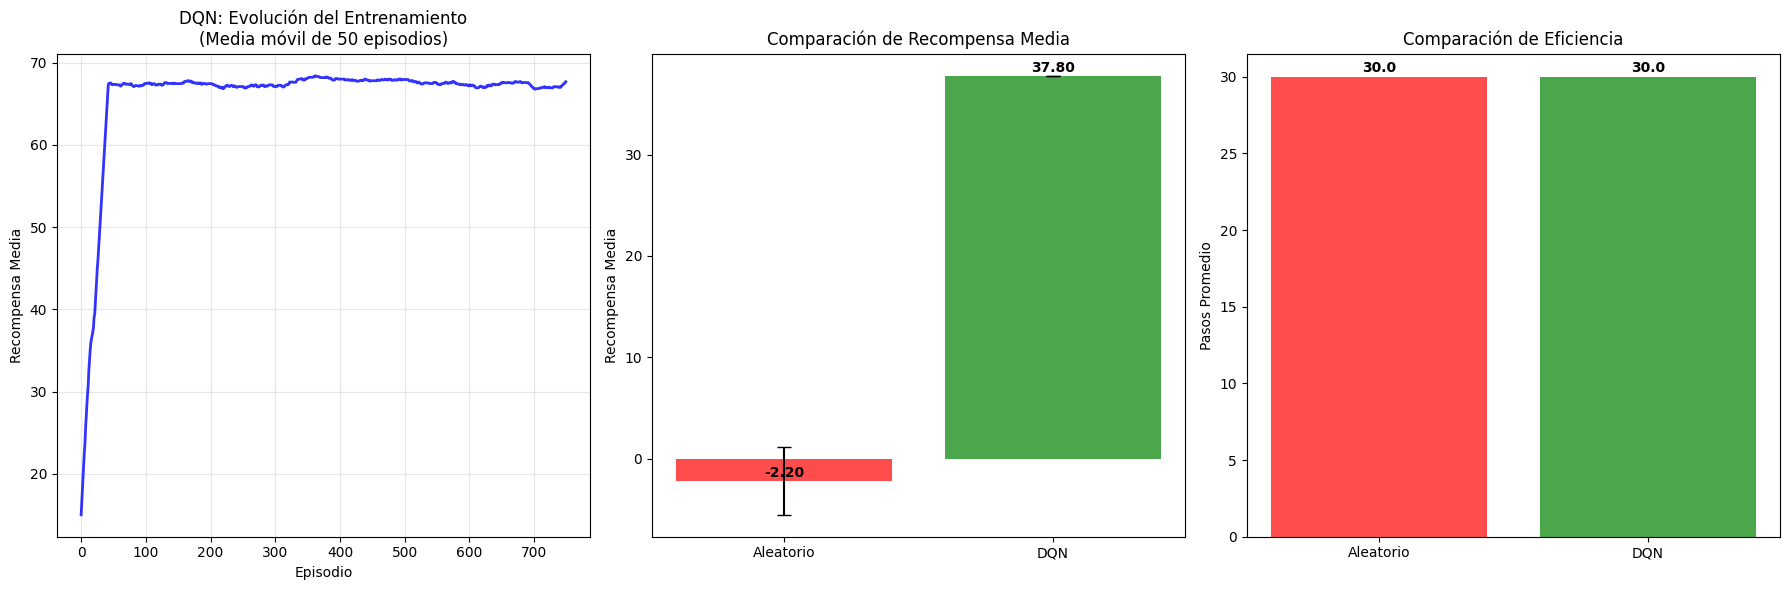


🧠 ANÁLISIS DE Q-VALUES FINALES

Q-values para estados clave:

Estado (0, 0):
  Mejor acción: →
  Q-values: [↑:21.732, →:22.930, ↓:22.884, ←:21.649]

Estado (0, 5):
  Mejor acción: ↓
  Q-values: [↑:16.505, →:16.104, ↓:18.158, ←:16.452]

Estado (5, 0):
  Mejor acción: ↓
  Q-values: [↑:26.195, →:28.446, ↓:28.559, ←:27.325]

Estado (5, 5):
  Mejor acción: ↓
  Q-values: [↑:22.774, →:23.142, ↓:23.478, ←:23.237]

Estado (8, 8):
  Mejor acción: ←
  Q-values: [↑:16.328, →:16.751, ↓:16.467, ←:17.293]

Estado (9, 8):
  Mejor acción: ←
  Q-values: [↑:15.688, →:16.111, ↓:16.421, ←:16.944]

🎯 RESUMEN FINAL DQN

📁 ARCHIVOS GUARDADOS:
  • Imágenes PNG: estados_dqn/aleatorio/ y estados_dqn/dqn/
  • GIFs animados: estados_dqn/aleatorio_episodio_XXX.gif
  • GIFs animados: estados_dqn/dqn_episodio_XXX.gif
  • Gráfico comparativo: estados_dqn/comparacion_final_dqn.png

📈 MEJORA DEL DQN:
  • Recompensa: +1815.1%
  • Éxitos: +0%
  • Eficiencia: 0.0 pasos menos

🎮 CARACTERÍSTICAS OBSERVABLES:
  • Agente Alea

In [ ]:
# Instalar dependencias
# !pip install gymnasium matplotlib numpy torch pillow

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import gymnasium as gym
from collections import deque
import random

# =============================================================================
# AMBIENTE 10x10 (EL MISMO)
# =============================================================================

class GridWorld10x10:
    def __init__(self):
        self.size = 10
        self.meta = (9, 9)
        self.inicio = (0, 0)
        self.estado_actual = self.inicio
        
        self.obstaculos = [
            (2, 2), (2, 3), (2, 4),
            (5, 5), (5, 6), (5, 7), (5, 8),
            (7, 1), (7, 2), (7, 3),
            (8, 6), (8, 7), (9, 6)
        ]
        
        self.premios = {
            (3, 3): 2,
            (6, 2): 3,  
            (8, 8): 5,
        }
        
    def reset(self):
        self.estado_actual = self.inicio
        return self.estado_actual
        
    def step(self, accion):
        fila, col = self.estado_actual
        fila_anterior, col_anterior = fila, col
        
        if accion == 0 and fila > 0:
            fila -= 1
        elif accion == 1 and col < self.size - 1:
            col += 1
        elif accion == 2 and fila < self.size - 1:
            fila += 1
        elif accion == 3 and col > 0:
            col -= 1
        
        nuevo_estado = (fila, col)
        
        if nuevo_estado in self.obstaculos:
            nuevo_estado = (fila_anterior, col_anterior)
            recompensa = -2
        elif nuevo_estado in self.premios:
            recompensa = self.premios[nuevo_estado]
        elif nuevo_estado == self.meta:
            recompensa = 10
        else:
            distancia_anterior = abs(fila_anterior - 9) + abs(col_anterior - 9)
            distancia_actual = abs(fila - 9) + abs(col - 9)
            
            if distancia_actual < distancia_anterior:
                recompensa = 0.1
            elif distancia_actual > distancia_anterior:
                recompensa = -0.1
            else:
                recompensa = -0.05
        
        self.estado_actual = nuevo_estado
        terminado = (nuevo_estado == self.meta)
        
        return nuevo_estado, recompensa, terminado, False, {}
    
    def get_estado_tensor(self, estado):
        """Convertir estado a tensor para la red neuronal"""
        fila, col = estado
        estado_tensor = torch.zeros(self.size * self.size)
        estado_idx = fila * self.size + col
        estado_tensor[estado_idx] = 1.0
        return estado_tensor

# =============================================================================
# RED DQN
# =============================================================================

class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

class AgenteDQN:
    def __init__(self, input_size, output_size, lr=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.01, memory_size=10000, batch_size=32):
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        
        # Redes neuronal
        self.q_network = DQN(input_size, output_size)
        self.target_network = DQN(input_size, output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.memory = deque(maxlen=memory_size)
        
        # Inicializar target network
        self.actualizar_target_network()
    
    def actualizar_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def guardar_experiencia(self, estado, accion, recompensa, siguiente_estado, terminado):
        self.memory.append((estado, accion, recompensa, siguiente_estado, terminado))
    
    def seleccionar_accion(self, estado_tensor, modo="aprendizaje"):
        if modo == "aleatorio":
            return np.random.randint(self.output_size)
        elif modo == "aprendizaje":
            if np.random.random() <= self.epsilon:
                return np.random.randint(self.output_size)
            else:
                with torch.no_grad():
                    q_values = self.q_network(estado_tensor)
                    return torch.argmax(q_values).item()
        else:  # modo "explotacion"
            with torch.no_grad():
                q_values = self.q_network(estado_tensor)
                return torch.argmax(q_values).item()
    
    def obtener_q_values(self, estado_tensor):
        """Obtener todos los Q-values para un estado (para visualización)"""
        with torch.no_grad():
            return self.q_network(estado_tensor).numpy()
    
    def entrenar(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Samplear batch aleatorio
        batch = random.sample(self.memory, self.batch_size)
        estados, acciones, recompensas, siguientes_estados, terminados = zip(*batch)
        
        # Convertir a tensores
        estados = torch.stack(estados)
        acciones = torch.LongTensor(acciones)
        recompensas = torch.FloatTensor(recompensas)
        siguientes_estados = torch.stack(siguientes_estados)
        terminados = torch.BoolTensor(terminados)
        
        # Q-values actuales
        q_actual = self.q_network(estados).gather(1, acciones.unsqueeze(1))
        
        # Q-values objetivo
        with torch.no_grad():
            max_q_siguiente = self.target_network(siguientes_estados).max(1)[0]
            objetivo = recompensas + self.gamma * max_q_siguiente * ~terminados
        
        # Calcular pérdida
        perdida = nn.MSELoss()(q_actual.squeeze(), objetivo)
        
        # Backpropagation
        self.optimizer.zero_grad()
        perdida.backward()
        self.optimizer.step()
        
        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# =============================================================================
# VISUALIZACIÓN Y GUARDADO DE ESTADOS
# =============================================================================

def crear_visualizacion_grid(env, agente, agente_tipo, episodio, paso, accion=None, q_values=None):
    """Crear imagen del estado actual del grid"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # ===========================================
    # SUBPLOT 1: MAPA DEL GRID
    # ===========================================
    # Crear matriz de colores
    grid_colores = np.zeros((env.size, env.size, 3))
    
    # Colores base (verde claro para espacios vacíos)
    grid_colores[:, :, 1] = 0.8
    
    # Obstáculos (gris)
    for obs in env.obstaculos:
        grid_colores[obs] = [0.5, 0.5, 0.5]
    
    # Premios (amarillo)
    for premio_pos in env.premios:
        grid_colores[premio_pos] = [1.0, 1.0, 0.0]
    
    # Meta (azul)
    grid_colores[env.meta] = [0.0, 0.0, 1.0]
    
    # Agente (rojo)
    grid_colores[env.estado_actual] = [1.0, 0.0, 0.0]
    
    # Mostrar grid
    ax1.imshow(grid_colores)
    
    # Añadir texto informativo
    accion_texto = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    accion_str = accion_texto.get(accion, 'Inicio')
    
    titulo = f"Agente: {agente_tipo}\nEpisodio: {episodio}, Paso: {paso}\nAcción: {accion_str}"
    ax1.set_title(titulo, fontsize=14, fontweight='bold')
    
    # Añadir coordenadas y símbolos
    for i in range(env.size):
        for j in range(env.size):
            texto = ""
            color = "white"
            
            if (i, j) == env.estado_actual:
                texto = "X"
                color = "white"
            elif (i, j) == env.meta:
                texto = "G"
                color = "white"
            elif (i, j) in env.obstaculos:
                texto = "█"
                color = "white"
            elif (i, j) in env.premios:
                texto = str(env.premios[(i, j)])
                color = "black"
            
            if texto:
                ax1.text(j, i, texto, ha='center', va='center', 
                       fontsize=10, fontweight='bold', color=color)
    
    ax1.set_xticks(range(env.size))
    ax1.set_yticks(range(env.size))
    ax1.grid(which='both', color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # ===========================================
    # SUBPLOT 2: Q-VALUES (solo para DQN)
    # ===========================================
    if q_values is not None:
        acciones = ['↑ ARRIBA', '→ DERECHA', '↓ ABAJO', '← IZQUIERDA']
        colores = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
        
        bars = ax2.barh(acciones, q_values, color=colores, alpha=0.7)
        ax2.set_title('Q-Values por Acción', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Valor Q')
        ax2.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, valor in zip(bars, q_values):
            ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    f'{valor:.3f}', va='center', fontweight='bold')
        
        # Destacar la mejor acción
        mejor_accion = np.argmax(q_values)
        bars[mejor_accion].set_color('gold')
        bars[mejor_accion].set_alpha(1.0)
        
        # Información adicional
        info_text = f"ε (exploración): {agente.epsilon:.3f}\n"
        info_text += f"Mejor acción: {acciones[mejor_accion]}\n"
        info_text += f"Valor Q máximo: {np.max(q_values):.3f}"
        
        ax2.text(0.05, 0.95, info_text, transform=ax2.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'Q-Values no disponibles\n(Agente Aleatorio)', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Q-Values por Acción', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

def guardar_estado(env, agente, agente_tipo, episodio, paso, accion=None, carpeta="estados_dqn"):
    """Guardar el estado actual como imagen PNG"""
    # Crear carpeta si no existe
    carpeta_agente = os.path.join(carpeta, agente_tipo)
    os.makedirs(carpeta_agente, exist_ok=True)
    
    # Obtener Q-values si es agente DQN
    q_values = None
    if agente_tipo == "dqn" and agente is not None:
        estado_tensor = env.get_estado_tensor(env.estado_actual)
        q_values = agente.obtener_q_values(estado_tensor)
    
    # Crear visualización
    fig = crear_visualizacion_grid(env, agente, agente_tipo, episodio, paso, accion, q_values)
    
    # Guardar imagen
    filename = f"{carpeta_agente}/episodio_{episodio:03d}_paso_{paso:03d}.png"
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)
    
    return filename

# =============================================================================
# DEMOSTRACIÓN: AGENTE ALEATORIO vs DQN
# =============================================================================

def demostrar_dqn_10x10():
    print("=" * 70)
    print("🎮 MUNDO 10x10 - DEEP Q-LEARNING (DQN)")
    print("=" * 70)
    
    # Crear carpetas para los estados
    carpetas = ["estados_dqn/aleatorio", "estados_dqn/dqn"]
    for carpeta in carpetas:
        os.makedirs(carpeta, exist_ok=True)
    
    env = GridWorld10x10()
    
    # =======================================================================
    # FASE 1: AGENTE ALEATORIO (NO ENTRENADO)
    # =======================================================================
    print("\n🔴 FASE 1: AGENTE ALEATORIO (NO ENTRENADO)")
    
    # Agente "aleatorio" para comparación
    class AgenteAleatorio:
        def seleccionar_accion(self, estado_tensor, modo="aleatorio"):
            return np.random.randint(4)
        def obtener_q_values(self, estado_tensor):
            return None
    
    agente_aleatorio = AgenteAleatorio()
    
    episodios_ejemplo = 2
    
    for episodio in range(episodios_ejemplo):
        estado = env.reset()
        estado_tensor = env.get_estado_tensor(estado)
        recompensa_total = 0
        pasos = 0
        terminado = False
        
        print(f"\n📹 Grabando Episodio {episodio + 1} - Agente Aleatorio")
        
        # Guardar estado inicial
        guardar_estado(env, agente_aleatorio, "aleatorio", episodio, 0)
        
        while not terminado and pasos < 25:
            # Acción aleatoria
            accion = agente_aleatorio.seleccionar_accion(estado_tensor)
            siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
            siguiente_estado_tensor = env.get_estado_tensor(siguiente_estado)
            
            # Guardar estado después de la acción
            guardar_estado(env, agente_aleatorio, "aleatorio", episodio, pasos + 1, accion)
            
            estado = siguiente_estado
            estado_tensor = siguiente_estado_tensor
            recompensa_total += recompensa
            pasos += 1
            
            if terminado:
                print(f"  ✅ Episodio {episodio + 1}: Llegó a meta en {pasos} pasos")
                break
            elif pasos >= 25:
                print(f"  ⏰ Episodio {episodio + 1}: Se agotaron los pasos")
    
    # =======================================================================
    # FASE 2: ENTRENAMIENTO DQN
    # =======================================================================
    print("\n" + "=" * 50)
    print("🔄 ENTRENANDO DQN (800 episodios)...")
    print("=" * 50)
    
    agente_dqn = AgenteDQN(
        input_size=100,    # 10x10 estados
        output_size=4,     # 4 acciones
        lr=0.001,
        gamma=0.95,
        epsilon=1.0,       # 100% exploración inicial
        epsilon_decay=0.998,
        epsilon_min=0.01,
        memory_size=10000,
        batch_size=32
    )
    
    recompensas_entrenamiento = []
    actualizaciones_target = 0
    
    for episodio in range(800):
        estado = env.reset()
        estado_tensor = env.get_estado_tensor(estado)
        recompensa_episodio = 0
        terminado = False
        pasos_episodio = 0
        
        while not terminado and pasos_episodio < 50:
            accion = agente_dqn.seleccionar_accion(estado_tensor, modo="aprendizaje")
            siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
            siguiente_estado_tensor = env.get_estado_tensor(siguiente_estado)
            
            # Guardar experiencia
            agente_dqn.guardar_experiencia(
                estado_tensor, accion, recompensa, siguiente_estado_tensor, terminado
            )
            
            # Entrenar
            agente_dqn.entrenar()
            
            estado = siguiente_estado
            estado_tensor = siguiente_estado_tensor
            recompensa_episodio += recompensa
            pasos_episodio += 1
        
        recompensas_entrenamiento.append(recompensa_episodio)
        
        # Actualizar target network cada 10 episodios
        if episodio % 10 == 0:
            agente_dqn.actualizar_target_network()
            actualizaciones_target += 1
        
        if episodio % 100 == 0:
            avg_reward = np.mean(recompensas_entrenamiento[-100:]) if len(recompensas_entrenamiento) >= 100 else np.mean(recompensas_entrenamiento)
            print(f"Episodio {episodio}: Recompensa = {recompensa_episodio:.2f}, "
                  f"ε = {agente_dqn.epsilon:.3f}, Media = {avg_reward:.2f}")
    
    # =======================================================================
    # FASE 3: AGENTE DQN ENTRENADO
    # =======================================================================
    print("\n" + "=" * 50)
    print("🟢 FASE 3: AGENTE DQN ENTRENADO")
    print("=" * 50)
    
    for episodio in range(episodios_ejemplo):
        estado = env.reset()
        estado_tensor = env.get_estado_tensor(estado)
        recompensa_total = 0
        pasos = 0
        terminado = False
        
        print(f"\n📹 Grabando Episodio {episodio + 1} - DQN")
        
        # Guardar estado inicial con Q-values
        guardar_estado(env, agente_dqn, "dqn", episodio, 0)
        
        while not terminado and pasos < 25:
            # Usar política entrenada (sin exploración)
            accion = agente_dqn.seleccionar_accion(estado_tensor, modo="explotacion")
            siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
            siguiente_estado_tensor = env.get_estado_tensor(siguiente_estado)
            
            # Guardar estado con Q-values
            guardar_estado(env, agente_dqn, "dqn", episodio, pasos + 1, accion)
            
            estado = siguiente_estado
            estado_tensor = siguiente_estado_tensor
            recompensa_total += recompensa
            pasos += 1
            
            if terminado:
                print(f"  ✅ Episodio {episodio + 1}: Llegó a meta en {pasos} pasos")
                break
            elif pasos >= 25:
                print(f"  ⏰ Episodio {episodio + 1}: Se agotaron los pasos")
    
    # =======================================================================
    # CREAR GIFS ANIMADOS
    # =======================================================================
    print("\n" + "=" * 50)
    print("🎬 CREANDO GIFS ANIMADOS...")
    print("=" * 50)
    
    def crear_gif_episodio(agente_tipo, episodio, duracion_frame=400):
        """Crear GIF a partir de las imágenes de un episodio"""
        carpeta = f"estados_dqn/{agente_tipo}"
        imagenes = []
        
        # Encontrar todas las imágenes del episodio
        for archivo in sorted(os.listdir(carpeta)):
            if archivo.startswith(f"episodio_{episodio:03d}_paso_"):
                path = os.path.join(carpeta, archivo)
                imagenes.append(Image.open(path))
        
        if imagenes:
            # Guardar GIF
            gif_path = f"estados_dqn/{agente_tipo}_episodio_{episodio:03d}.gif"
            imagenes[0].save(
                gif_path,
                save_all=True,
                append_images=imagenes[1:],
                duration=duracion_frame,
                loop=0
            )
            print(f"  ✅ GIF creado: {gif_path}")
            return gif_path
        return None
    
    # Crear GIFs para cada episodio
    for episodio in range(episodios_ejemplo):
        crear_gif_episodio("aleatorio", episodio)
        crear_gif_episodio("dqn", episodio)
    
    # =======================================================================
    # COMPARACIÓN ESTADÍSTICA
    # =======================================================================
    print("\n" + "=" * 70)
    print("📊 COMPARACIÓN ESTADÍSTICA")
    print("=" * 70)
    
    def evaluar_agente(env, agente, n_episodios=100, es_dqn=False):
        recompensas = []
        exitos = 0
        pasos_promedio = 0
        
        for _ in range(n_episodios):
            estado = env.reset()
            if es_dqn:
                estado_tensor = env.get_estado_tensor(estado)
            recompensa_episodio = 0
            pasos = 0
            terminado = False
            
            while not terminado and pasos < 30:
                if es_dqn:
                    accion = agente.seleccionar_accion(estado_tensor, modo="explotacion")
                    siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
                    estado_tensor = env.get_estado_tensor(siguiente_estado)
                else:
                    accion = np.random.randint(4)
                    siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
                
                estado = siguiente_estado
                recompensa_episodio += recompensa
                pasos += 1
            
            recompensas.append(recompensa_episodio)
            if terminado:
                exitos += 1
            pasos_promedio += pasos
        
        return {
            'recompensa_media': np.mean(recompensas),
            'exitos': exitos,
            'pasos_promedio': pasos_promedio / n_episodios,
            'std_recompensa': np.std(recompensas)
        }
    
    stats_aleatorio = evaluar_agente(env, None, 100, False)
    stats_dqn = evaluar_agente(env, agente_dqn, 100, True)
    
    print(f"\n🔴 AGENTE ALEATORIO (100 episodios):")
    print(f"   • Recompensa media: {stats_aleatorio['recompensa_media']:.2f} ± {stats_aleatorio['std_recompensa']:.2f}")
    print(f"   • Tasa de éxito: {stats_aleatorio['exitos']}%")
    print(f"   • Pasos promedio: {stats_aleatorio['pasos_promedio']:.1f}")
    
    print(f"\n🟢 DQN (100 episodios):")
    print(f"   • Recompensa media: {stats_dqn['recompensa_media']:.2f} ± {stats_dqn['std_recompensa']:.2f}")
    print(f"   • Tasa de éxito: {stats_dqn['exitos']}%")
    print(f"   • Pasos promedio: {stats_dqn['pasos_promedio']:.1f}")
    print(f"   • ε final: {agente_dqn.epsilon:.4f}")
    
    # =======================================================================
    # GRÁFICOS COMPARATIVOS
    # =======================================================================
    plt.figure(figsize=(18, 6))
    
    # Gráfico 1: Evolución del entrenamiento
    plt.subplot(1, 3, 1)
    ventana = 50
    if len(recompensas_entrenamiento) > ventana:
        media_movil = [np.mean(recompensas_entrenamiento[i:i+ventana]) 
                      for i in range(len(recompensas_entrenamiento)-ventana)]
        plt.plot(media_movil, color='blue', alpha=0.8, linewidth=2)
    else:
        plt.plot(recompensas_entrenamiento, color='blue', alpha=0.8, linewidth=2)
    
    plt.title('DQN: Evolución del Entrenamiento\n(Media móvil de 50 episodios)')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Media')
    plt.grid(True, alpha=0.3)
    
    # Gráfico 2: Comparación de recompensas
    plt.subplot(1, 3, 2)
    categorias = ['Aleatorio', 'DQN']
    medias = [stats_aleatorio['recompensa_media'], stats_dqn['recompensa_media']]
    errores = [stats_aleatorio['std_recompensa'], stats_dqn['std_recompensa']]
    
    barras = plt.bar(categorias, medias, yerr=errores, capsize=5, 
                    color=['red', 'green'], alpha=0.7)
    plt.title('Comparación de Recompensa Media')
    plt.ylabel('Recompensa Media')
    
    for barra, valor in zip(barras, medias):
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.1, 
                f'{valor:.2f}', ha='center', va='bottom', fontweight='bold')
    
 
    
    for barra, valor in zip(barras, pasos):
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.1, 
                f'{valor:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('estados_dqn/comparacion_final_dqn.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # =======================================================================
    # ANÁLISIS DE Q-VALUES FINALES
    # =======================================================================
    print("\n" + "=" * 70)
    print("🧠 ANÁLISIS DE Q-VALUES FINALES")
    print("=" * 70)
    
    # Mostrar Q-values para algunos estados clave
    estados_clave = [(0, 0), (0, 5), (5, 0), (5, 5), (8, 8), (9, 8)]
    
    print("\nQ-values para estados clave:")
    for estado in estados_clave:
        estado_tensor = env.get_estado_tensor(estado)
        q_values = agente_dqn.obtener_q_values(estado_tensor)
        mejor_accion = np.argmax(q_values)
        accion_texto = ['↑', '→', '↓', '←'][mejor_accion]
        
        print(f"\nEstado {estado}:")
        print(f"  Mejor acción: {accion_texto}")
        print(f"  Q-values: [↑:{q_values[0]:.3f}, →:{q_values[1]:.3f}, ↓:{q_values[2]:.3f}, ←:{q_values[3]:.3f}]")
    
    # =======================================================================
    # RESUMEN FINAL
    # =======================================================================
    print("\n" + "=" * 70)
    print("🎯 RESUMEN FINAL DQN")
    print("=" * 70)
    
    print(f"\n📁 ARCHIVOS GUARDADOS:")
    print(f"  • Imágenes PNG: estados_dqn/aleatorio/ y estados_dqn/dqn/")
    print(f"  • GIFs animados: estados_dqn/aleatorio_episodio_XXX.gif")
    print(f"  • GIFs animados: estados_dqn/dqn_episodio_XXX.gif")
    print(f"  • Gráfico comparativo: estados_dqn/comparacion_final_dqn.png")
    
    mejora = ((stats_dqn['recompensa_media'] - stats_aleatorio['recompensa_media']) / 
              abs(stats_aleatorio['recompensa_media'])) * 100
    
    print(f"\n📈 MEJORA DEL DQN:")
    print(f"  • Recompensa: {mejora:+.1f}%")
    print(f"  • Éxitos: +{stats_dqn['exitos'] - stats_aleatorio['exitos']}%")
    print(f"  • Eficiencia: {stats_aleatorio['pasos_promedio'] - stats_dqn['pasos_promedio']:.1f} pasos menos")
    
    print(f"\n🎮 CARACTERÍSTICAS OBSERVABLES:")
    print(f"  • Agente Aleatorio: Movimientos erráticos, Q-values no mostrados")
    print(f"  • DQN: Trayectoria optimizada, Q-values mostrados en gráfico de barras")
    print(f"  • DQN: Barra dorada indica la mejor acción según Q-values")
    print(f"  • DQN: ε (exploración) disminuye durante el entrenamiento")

# Ejecutar la demostración
demostrar_dqn_10x10()